In [1]:
%matplotlib notebook
import numpy as np
import scipy

from scipy import sparse
from scipy.sparse import linalg
from numpy import pi, sin

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import animation

def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

<IPython.core.display.Javascript object>


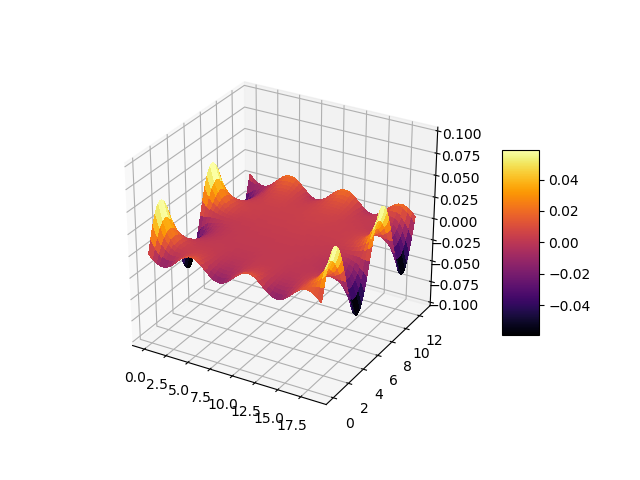

In [2]:
def mu(x,y):
    z = np.zeros((len(y),len(x)), dtype=np.longdouble)
    for i in range(len(x)):
        for j in range(len(y)):
            z[j][i] = -0.01*sin(x[i]) + 0.05*sin(y[j])
    return z

a = 6*pi
b = 4*pi
T = 10
hx = pi/30
hy = hx
k = 1.0
eps = 1e-12

lambda_x = (pi/a)**2*k
lambda_xN = 4.0*(k/hx**2)
lambda_y = (pi/b)**2*k
lambda_yN = 4.0*(k/hy**2)

lambda_min = min(lambda_x, lambda_y)
lambda_max = max(lambda_xN, lambda_yN)

tau_min = 2.0/lambda_max
tau_max = 2.0/lambda_min

S = int(np.ceil(1/8.0 * np.log(1/eps) * np.log(lambda_max/lambda_min)))
t = np.array([np.exp(np.log(tau_min) + i*np.log(tau_max/tau_min)/(S-1)) for i in range(S)], dtype=np.longdouble)

x = np.arange(0, a+hx, hx)
y = np.arange(0, b+hy, hy)

u = np.zeros((len(t)+1, len(y), len(x)))
u[0] = mu(x,y)
for i in range(1,len(t)):
    u[i,0,:] = np.squeeze(mu(x,[0]))
    u[i,-1,:] = np.squeeze(mu(x,[b]))
    u[i,:,0] = np.squeeze(mu([0],y))
    u[i,:,-1] = np.squeeze(mu([a],y))

diff_op_x = np.zeros((len(x),len(x)),dtype= np.float64)
for n in range(1, len(x)-1):
    diff_op_x[n][n-1] = 1
    diff_op_x[n][n] = -2
    diff_op_x[n][n+1] = 1
diff_op_x = np.matrix(diff_op_x)
diff_op_x = k/hx**2 * diff_op_x.T


diff_op_y = np.zeros((len(y),len(y)), dtype= np.float64)
for n in range(1, len(y)-1):
    diff_op_y[n][n-1] = 1
    diff_op_y[n][n] = -2
    diff_op_y[n][n+1] = 1
diff_op_y = np.matrix(diff_op_y)
diff_op_y = k/hy**2 * diff_op_y

du_ = []
for i in range(len(t)):
    tau  = t[i]
    Px = np.matrix(np.eye(len(x)) - np.matrix(tau*diff_op_x/2.0));
    Py = np.matrix(np.eye(len(y)) - np.matrix(tau*diff_op_y/2.0));
    F = np.matrix(u[i])*diff_op_x + diff_op_y*np.matrix(u[i])
    F[0,:] = np.zeros(F[0,:].shape)
    F[-1,:] = np.zeros(F[-1,:].shape)
    F[:,0] = np.zeros(F[:,0].shape)
    F[:,-1] = np.zeros(F[:,-1].shape)
    nu = np.linalg.solve(Px.T, F.T).T
    du = np.linalg.solve(Py, nu)
    du_.append(du)
    u[i+1] = np.matrix(u[i]) + tau*np.matrix(du)
    

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, u[0], cmap=cm.inferno, linewidth=1, antialiased=True)

# Customize the z axis.
ax.set_zlim(-0.1,0.1)
ax.set_xlim(0,a)
ax.set_ylim(0,b)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

def animate(n):
    ax.clear()
    ax.set_zlim(-0.1,0.1)
    surf = ax.plot_surface(X, Y, u[n], cmap=cm.inferno, linewidth=0, antialiased=False)
    return surf,

anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=100, repeat = False)

plt.show()


<IPython.core.display.Javascript object>


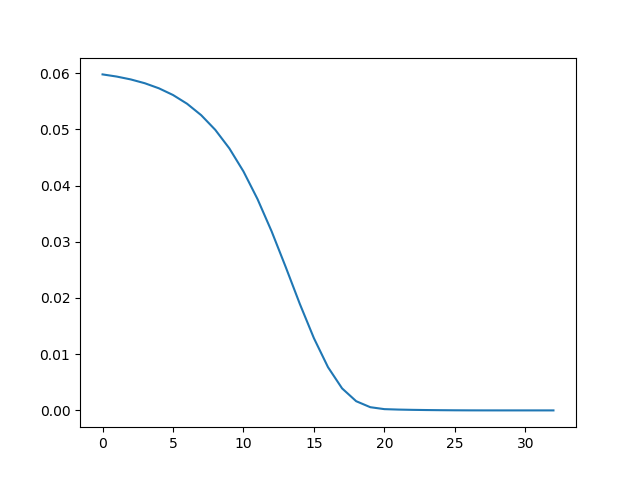

In [3]:
plt.figure()
plt.plot([max(abs(np.asarray(p).reshape(-1))) for p in [t for t in du_]])